In [2]:
#This notebook checks the Planck lensing data

import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from colossus.cosmology import cosmology
import scipy.interpolate as I
from src.template_generator import *
from pylab import arange, show, cm

%matplotlib inline

def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

In [2]:
#read data and calculate kappa and phi map
mask=hp.read_map('/Volumes/My Passport/cosmology/sdss3/planck_data/data_cmb_lensing/mask.fits.gz')
alms=hp.read_alm('/Volumes/My Passport/cosmology/sdss3/planck_data/data_cmb_lensing/dat_klm.fits')
l, m = hp.Alm.getlm(lmax=2048)
k_map = hp.sphtfunc.alm2map(alms,nside=2048)
alms*=1./(l*(l+1))*2
alms[0]=0.
phi_map = hp.sphtfunc.alm2map(alms,nside=2048)

#prepare masks
mask_sdss=hp.read_map('/Volumes/My Passport/cosmology/sdss3/sdss3_dr12_mask/healpix_mask_LOWZ_North.fits')+hp.read_map('/Volumes/My Passport/cosmology/sdss3/sdss3_dr12_mask/healpix_mask_LOWZ_South.fits')
mask_sdss*=(hp.read_map('/Volumes/My Passport/cosmology/sdss3/sdss3_dr12_mask/healpix_mask_CMASS_North.fits')+hp.read_map('/Volumes/My Passport/cosmology/sdss3/sdss3_dr12_mask/healpix_mask_CMASS_South.fits'))
foo=np.where(mask_sdss>0)
mask_sdss[foo]=1

mask_sdss=hp.pixelfunc.ud_grade(mask_sdss, nside_out=256)
mask_new=change_coord(mask_sdss, 'CG')

#store prepared data
np.savez('cmb_lensig_analysis_meta_data',sdss_mask=np.array(mask_new),planck_mask=np.array(mask), planck_k_map = np.array(k_map) , planck_phi_map = np.array(phi_map) )

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/Users/jens/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jens/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/jens/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [2]:
#load meta data
data=np.load('cmb_lensig_analysis_meta_data.npz')

k_map       = data['planck_k_map']
phi_map     = data['planck_phi_map']
sdss_mask   = data['sdss_mask']
planck_mask = data['planck_mask']


sdss_mask=hp.pixelfunc.ud_grade(sdss_mask, nside_out=2048)

mask= planck_mask * sdss_mask

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


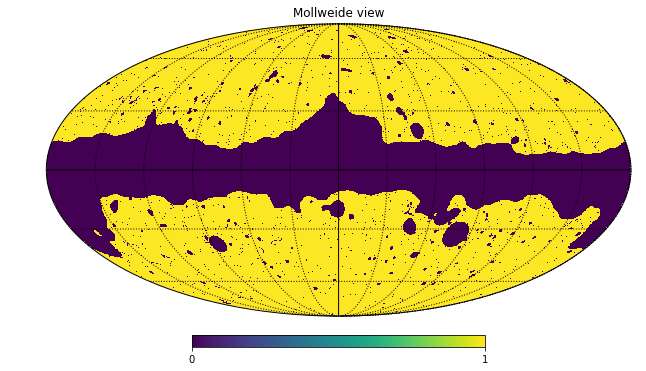

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


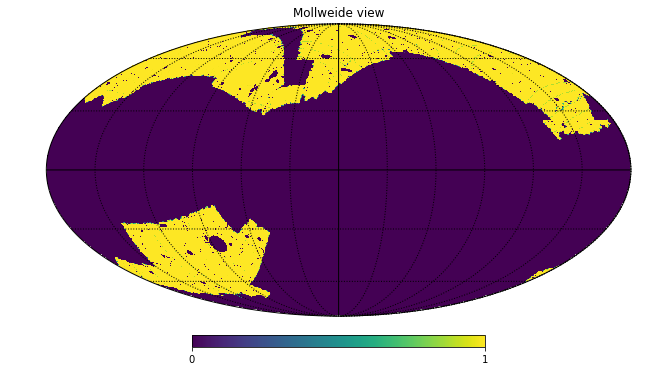

We are currently using only  0.3224004492776638 percent of the total planck sky


In [3]:
hp.mollview(planck_mask)
hp.graticule()
plt.show()

hp.mollview(mask)
hp.graticule()
plt.show()

print('We are currently using only ',np.sum(mask)/np.sum(planck_mask),'percent of the total planck sky')


In [4]:
#process files
data = np.load('borg_kappa_maps.npz')
xmin=-0.015
xmax=0.015

res=[]
cnt=0
for m in data['kappa']:
    print('Processing sample nr: ', cnt)
    borg_kappa = hp.pixelfunc.ud_grade(m, nside_out=2048)
    foo        = np.where(mask>0.0) #only take non-masked pixel
    a1         = borg_kappa[foo][::1]
    a2         = k_map[foo][::1]
    nn1, bin_edges = np.histogram(a1, bins=20, range=[xmin,xmax])
    ww1, bin_edges = np.histogram(a1, weights=a2, bins=20, range=[xmin,xmax])
    res.append(ww1/(nn1).astype(float))
    cnt+=1

'''    
data = np.load('theory_kappa_maps.npz')  
res_th=[]
cnt=0
for m in data['kappa']:
    print('Processing sample nr: ', cnt)
    aux=hp.pixelfunc.ud_grade(m, nside_out=2048)
    foo=np.where(mask>0.0) #only take non-masked pixel
    a1=aux[foo][::1]
    a2=k_map[foo][::1]
    nn1, bin_edges = np.histogram(a1, bins=20, range=[xmin,xmax])
    ww1, bin_edges = np.histogram(a1, weights=a2, bins=20, range=[xmin,xmax])
    res_th.append(ww1/(nn1).astype(float))
    cnt+=1
'''   
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])

Processing sample nr:  0
Processing sample nr:  1
Processing sample nr:  2
Processing sample nr:  3
Processing sample nr:  4
Processing sample nr:  5
Processing sample nr:  6
Processing sample nr:  7
Processing sample nr:  8
Processing sample nr:  9
Processing sample nr:  10
Processing sample nr:  11
Processing sample nr:  12
Processing sample nr:  13
Processing sample nr:  14
Processing sample nr:  15
Processing sample nr:  16
Processing sample nr:  17
Processing sample nr:  18
Processing sample nr:  19
Processing sample nr:  20
Processing sample nr:  21
Processing sample nr:  22
Processing sample nr:  23
Processing sample nr:  24
Processing sample nr:  25
Processing sample nr:  26
Processing sample nr:  27
Processing sample nr:  28
Processing sample nr:  29
Processing sample nr:  30
Processing sample nr:  31
Processing sample nr:  32
Processing sample nr:  33
Processing sample nr:  34
Processing sample nr:  35
Processing sample nr:  36
Processing sample nr:  37
Processing sample nr: 

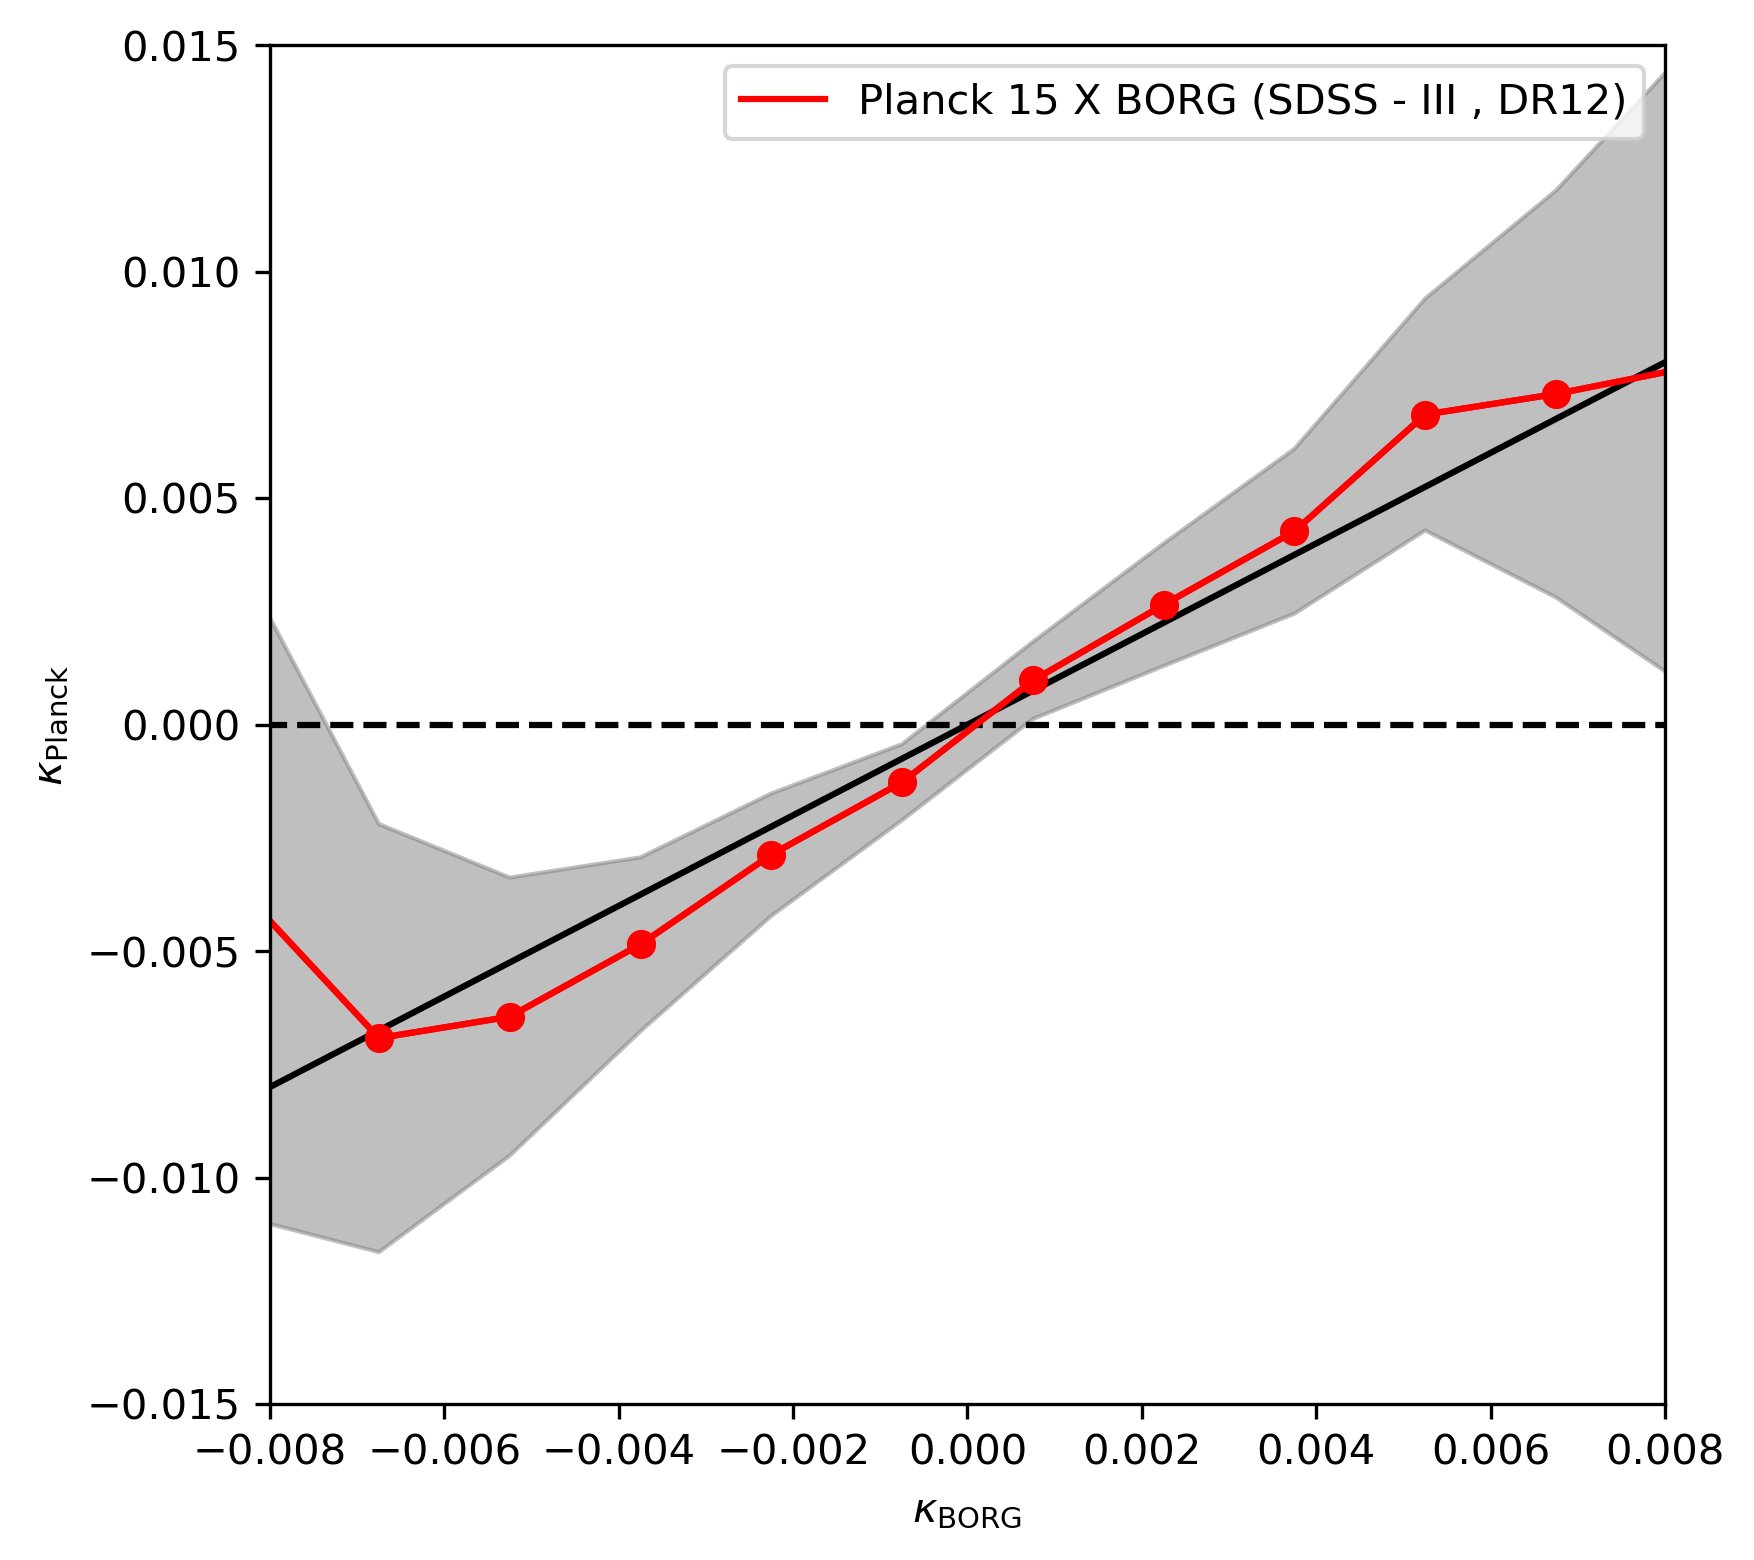

In [5]:
#plt.plot(bincenters,ww0/(nn0).astype(float))
#plt.plot(bincenters,ww0/(nn0).astype(float), label='Planck vs random theory')

mean=np.average(np.array(res),axis=0)
std=np.std(np.array(res),axis=0)

#mean_th=np.average(np.array(res_th),axis=0)
#std_th=np.std(np.array(res_th),axis=0)


fig, ax = plt.subplots(figsize=(6,6),dpi=300)


ax.plot(bincenters,bincenters*0, color='black', ls='--')
ax.plot(bincenters,bincenters, color='black')

#ax.plot(bincenters,mean_th, label='Planck vs RANDOM',color='blue')
#ax.plot(bincenters,mean_th, marker='o',color='blue')
#ax.fill_between(bincenters, mean_th-std_th, mean_th+std_th, color='blue',alpha=0.5)

ax.plot(bincenters,mean, label='Planck 15 X BORG (SDSS - III , DR12)',color='red')
ax.plot(bincenters,mean, marker='o',color='red')
#ax.plot(bincenters,mean,color='red')
#ax.fill_between(bincenters, mean-std, mean+std, color='salmon',alpha=0.5)
ax.fill_between(bincenters, mean-std, mean+std, color='gray',alpha=0.5)

ax.set_ylim([-0.015,0.015])
ax.set_xlim([-0.008,0.008])


plt.legend()

plt.xlabel(r'$\kappa_{\rm{BORG}}$'); plt.ylabel((r'$\kappa_{\rm{Planck}}$')); #plt.grid()
plt.savefig('borg_vs_planck_convergence.png', bbox_inches='tight', dpi=300)

Processing sample nr:  0
Processing sample nr:  1
Processing sample nr:  2
Processing sample nr:  3
Processing sample nr:  4
Processing sample nr:  5
Processing sample nr:  6
Processing sample nr:  7
Processing sample nr:  8
Processing sample nr:  9
Processing sample nr:  10
Processing sample nr:  11
Processing sample nr:  12
Processing sample nr:  13
Processing sample nr:  14
Processing sample nr:  15
Processing sample nr:  16
Processing sample nr:  17
Processing sample nr:  18
Processing sample nr:  19
Processing sample nr:  20
Processing sample nr:  21
Processing sample nr:  22
Processing sample nr:  23
Processing sample nr:  24
Processing sample nr:  25
Processing sample nr:  26
Processing sample nr:  27
Processing sample nr:  28
Processing sample nr:  29
Processing sample nr:  30
Processing sample nr:  31
Processing sample nr:  32
Processing sample nr:  33
Processing sample nr:  34
Processing sample nr:  35
Processing sample nr:  36
Processing sample nr:  37
Processing sample nr: 

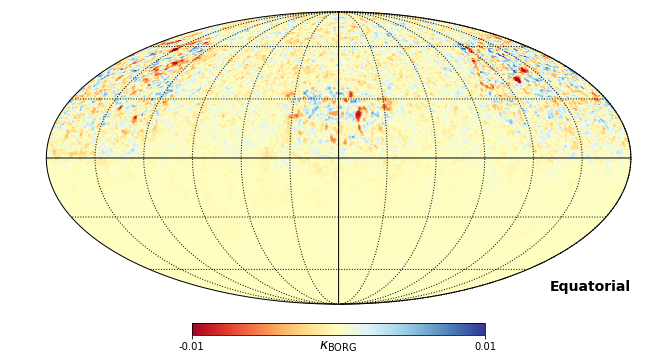

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/Users/jens/anaconda3/lib/python3.6/site-packages/healpy/projaxes.py:387: RuntimeWarning: invalid value encountered in greater
  w=np.where(d2 > threshold)[0]


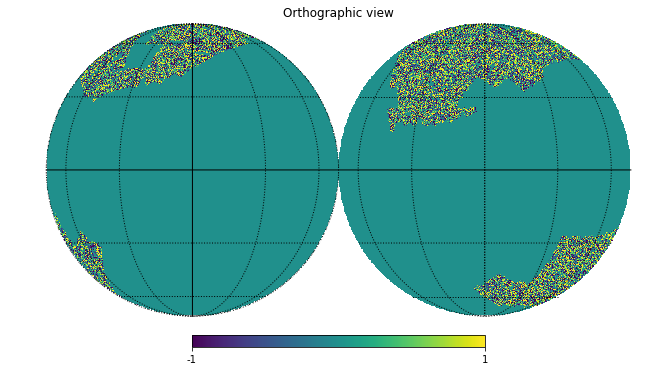

In [35]:
#process files
data = np.load('borg_kappa_maps.npz')
cnt=0

mean=data['kappa'][0]*0.
for m in data['kappa']:
    print('Processing sample nr: ', cnt)
    borg_kappa = hp.pixelfunc.ud_grade(m, nside_out=2048)
    mean+=m
    cnt+=1

mean/=cnt    


mm = hp.pixelfunc.ud_grade(mean, nside_out=2048)
'''
foo        = np.where(mask>0.0)
res, bin_edges = np.histogram(mm[foo]*720, bins=200, range=[-10.8,10.8],normed=True)
res1, bin_edges = np.histogram(k_map[foo], bins=200, range=[-10.8,10.8],normed=True)
bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
plt.plot(bincenters,res)
plt.plot(bincenters,res1)
plt.show()
'''

'''
nside = hp.npix2nside(len(mm))
# Get theta, phi for non-rotated map
t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi
# Define a rotator
r = hp.Rotator(deg=False, rot=[0,np.pi/2])

# Get theta, phi under rotated co-ordinates
trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
rot_map = hp.get_interp_val(mm, trot, prot)
'''

cmap = cm.RdYlBu
cmap.set_under('w')
hp.mollview(mm,cmap=cmap,coord=['G','C'] ,unit=r'$\kappa_{\rm{BORG}}$',min=-0.01,max=0.01, title='')
hp.graticule()

plt.savefig('borg_vs_planck_convergence_map.png', bbox_inches='tight', dpi=300)
plt.show()

hp.orthview(k_map*mask,min=-1,max=1)
hp.graticule()
plt.show()

In [ ]:
nside = hp.npix2nside(len(mm))

# Get theta, phi for non-rotated map
t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi

# Define a rotator
r0 = hp.Rotator(coord=['G','C'])
trot, prot = r0(t,p)
#r1 = hp.Rotator(deg=False, rot=[np.pi/2,0])
#trot, prot = r1(t,p)

rot_map = hp.get_interp_val(mm, trot, prot)

cmap = cm.RdYlBu
cmap.set_under('w')
hp.mollview(rot_map,cmap=cmap,unit=r'$\kappa_{\rm{BORG}}$',min=-0.01,max=0.01, title='')
hp.graticule()

plt.savefig('borg_vs_planck_convergence_map.png', bbox_inches='tight', dpi=300)
plt.show()

Processing sample nr:  0
Processing sample nr:  1
Processing sample nr:  2
Processing sample nr:  3
Processing sample nr:  4
Processing sample nr:  5
Processing sample nr:  6
Processing sample nr:  7
Processing sample nr:  8
Processing sample nr:  9
Processing sample nr:  10
Processing sample nr:  11
Processing sample nr:  12
Processing sample nr:  13
Processing sample nr:  14
Processing sample nr:  15
Processing sample nr:  16
Processing sample nr:  17
Processing sample nr:  18
Processing sample nr:  19
Processing sample nr:  20
Processing sample nr:  21
Processing sample nr:  22
Processing sample nr:  23
Processing sample nr:  24
Processing sample nr:  25
Processing sample nr:  26
Processing sample nr:  27
Processing sample nr:  28
Processing sample nr:  29
Processing sample nr:  30
Processing sample nr:  31
Processing sample nr:  32
Processing sample nr:  33
Processing sample nr:  34
Processing sample nr:  35
Processing sample nr:  36
Processing sample nr:  37
Processing sample nr: 

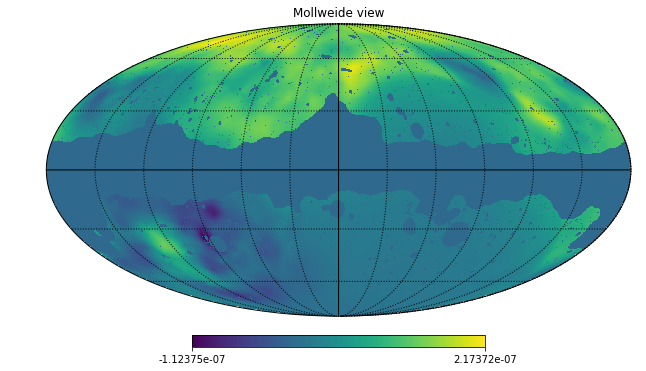

In [11]:
#process files
data = np.load('borg_time_delay_maps.npz')
cnt=0

mean=data['td'][0]*0.
for m in data['td']:
    print('Processing sample nr: ', cnt)
    #borg_kappa = hp.pixelfunc.ud_grade(m, nside_out=2048)
    mean+=m
    cnt+=1

mean/=cnt    
    
    
mean = hp.pixelfunc.ud_grade(mean, nside_out=2048)    
hp.mollview(-mean*planck_mask)
hp.graticule()
plt.show()


In [85]:
print(np.shape(k_map))
print(np.shape(mean))
print(np.shape(mask))


(50331648,)
(3145728,)
(50331648,)
